In [1]:
from PIL import Image
import numpy as np
import os
import matplotlib.pyplot as plt
import skimage.io
import skimage.color
import skimage.filters
import skfmm
import collections
import operator
import matplotlib.path as mpltPath
import cv2
from scipy.spatial import cKDTree


import xarray as xr
from cv2 import MORPH_CLOSE, morphologyEx
from skimage import morphology
from typing import List, Tuple, Union



from cv2 import MORPH_OPEN
from pywt._cwt import cwt
from scipy.ndimage import gaussian_filter
from scipy.ndimage.morphology import binary_dilation, binary_erosion, binary_fill_holes
from skimage import measure
from skimage.morphology import thin

C:\Users\huang\AppData\Local\Temp\ipykernel_3820\2269654253.py:28: DeprecationWarning: Please use `binary_dilation` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_dilation, binary_erosion, binary_fill_holes
C:\Users\huang\AppData\Local\Temp\ipykernel_3820\2269654253.py:28: DeprecationWarning: Please use `binary_erosion` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_dilation, binary_erosion, binary_fill_holes
C:\Users\huang\AppData\Local\Temp\ipykernel_3820\2269654253.py:28: DeprecationWarning: Please use `binary_fill_holes` from the `scipy.ndimage` namespace, the `scipy.ndimage.morphology` namespace is deprecated.
  from scipy.ndimage.morphology import binary_dilation, binary_erosion, binary_fill_holes


In [21]:
def curvature(ellipse):
    """
    the input of this function is levelset
    output is the curvature
    """
    small=1e-10
    
    [phiy,phix]=np.gradient(ellipse)
    phinorm=np.sqrt(np.square(phiy)+np.square(phix))
    ny=phiy/(phinorm+small)#avoid division by zero
    nx=phix/(phinorm+small)
    [_,nxx]=np.gradient(nx)
    [nyy,_]=np.gradient(ny)
    return nyy+nxx

In [2]:
def wavelet_mexh(image: xr.DataArray, wavelet_width: Union[float, List[float]]) -> xr.DataArray:
    """Compute the wavelet decomposition.

    Compute the 1d wavelet decomposition in x and y directions summing the two directions
    and coding it into uint8 gray scale levels.

    :param image: the image on which wavelet transform is applied
    :param wavelet_width: the wavelet scales to use
    :return wavelet: the 256 gray scale coding of the wavelet decomposition
    """
    wavelet: xr.DataArray = sum(
        xr.apply_ufunc(
            cwt,  # the function to apply
            image,  # on what array
            kwargs=dict(scales=wavelet_width, wavelet="mexh"),  # the function arguments
            input_core_dims=[[dim]],  # the input is 1D
            output_core_dims=[[dim], []],  # the output has the same size, plus another array
            vectorize=True,  # xarray is responsible for splitting the array into 1D vectors
        )[
            0  # we don't care about the other array
        ]
        for dim in image.dims
    )
    # the order of the dimensions may have changed
    wavelet = wavelet.transpose(*image.dims)

    # coding wt into 256 gray scale levels.
    wavelet = 255 * (wavelet - wavelet.min()) / (wavelet.max() - wavelet.min())
    wavelet.name = "Wavelet"
    return wavelet


# --------------------------------------------------------------------
def extract_objects(
    image: xr.DataArray,
    wavelet_width: Union[float, List[float]] = 10,
    threshold_global: float = 0.5,
    threshold_wavelet: float = 0.85,
) -> xr.DataArray:
    """Detect objects using two thresholds, global + wavelet.

    Detect objects using method of Blaisot & Yon Exp in Fluids 2005,
    section 3.2 i.e. detection using one global threshold based on the
    grey scale histogram and another one based on the wavelet
    decomposition to detect small/unfocused objects.
    """
    wavelet = wavelet_mexh(image, wavelet_width)

    hist_vec = np.linspace(1, 256, 255)
    hist_img, _ = np.histogram(image, hist_vec)
    hist_wt, _ = np.histogram(wavelet, hist_vec)

    # threshold_global = 0.5 generally works well
    threshold_img = threshold_global * hist_vec[hist_img.argmax()]

    # threshold_wt = 0.85 generally works well
    threshold_wt = threshold_wavelet * hist_vec[hist_wt.argmax()]

    mask1 = image <= threshold_img
    mask2 = wavelet <= threshold_wt
    imbin = mask1 | mask2

    # labels is the object number coded in gray scale
    labels = xr.apply_ufunc(
        measure.label,
        imbin,
    )
    labels.name = "Labels"

    print(f"--> {int(labels.max())} objects detected \n")

    return labels


# --------------------------------------------------------------------
def dilated_objects(labels: xr.DataArray, dilation_scale: int) -> xr.DataArray:
    """Compute, for each objects, the mask used for local binarisation.

    Dilate the detected objects to create a mask over which local
    contrast (p_min, p_max) and thus p_ref is calculated (see section
    3.3 of Blaisot & Yon, EiF 2005) Dilatation uses XOR algorithm, there
    is no overlap between dilated objects. For this end, the medial
    between objects is calculated and subtracted to the dilatated
    objects image
    """
    mask = labels >= 1

    mask1 = binary_dilation(mask, iterations=1)
    medial = thin(~mask1, max_num_iter=5)

    mask_dil1 = binary_dilation(mask, iterations=dilation_scale)
    mask_dil1[medial] = False

    mask_dil = binary_erosion(mask_dil1, iterations=1)

    labels_dil = xr.apply_ufunc(
        measure.label,
        mask_dil | mask,
    )

    return labels_dil


# --------------------------------------------------------------------
def extract_contours_from_threshold(
    image: xr.DataArray,
    threshold: float,
    remove_inclusion: bool = False,
) -> xr.DataArray:

    x: List[np.ndarray] = []
    y: List[np.ndarray] = []

    image = gaussian_filter(image, sigma=0.5, order=0)
    contours = measure.find_contours(image, threshold)

    if len(contours) > 1 and remove_inclusion:
        print("--> removing inclusions")
        remove_inclusion_contours(x, y, contours)

    else:
        for v in contours:
            x.append(v[:, 1])
            y.append(v[:, 0])

    return pack_contours(x, y)


# --------------------------------------------------------------------
def extract_contours(
    image: xr.DataArray,
    labels: xr.DataArray,
    remove_inclusion: bool = False,
    dilation_scale: int = 8,
    disk_size: float = 200,
    step_factor: int = 10,
    method: str = "histogram",
    tau: float = 0,
) -> xr.DataArray:
    """Extract coordinates of each object interface using a local threshold.

    - For each objects, it gets the local contrast C = (1 - pmin / pmax) / (1 + pmin / pmax), over the dilated
    object mask.
    - The parameter "l" appearing in Eq. 27 of Blaisot & Yon 2005, is then calculated from the local contrast C_0
    using a fourth order polynomial as fitted from Fig. 7 of Blaisot ICLASS 2012.
    - the local threshold p_ref = p_min + l*(p_max - p_min) defines the grey scale level of the interface
    - The contour coordinates (x,y) are obtained using the "measure.find_contours" module of skimage which
    interpolate to get local position at which the grey scale image = p_ref

    :param image: normalised image
    :param labels: labels of detected objects
    :param remove_inclusion: should the inclusions be removed
    :param dilation_scale: the dilation amplitude
    :param disk_size: size of the disk kernel used for removing the inclusion
    :param step_factor: the factor used to shrink the image for removing the inclusion
    :param method: method used to extract one particular contour list `histogram` or `min_max`
    :param tau: a parameter used to compute the local contrast
    :return x : the list of spatial coordinates of the objects using the local threshold p_ref, x coordinate
    :return y : the list of spatial coordinates of the objects using the local threshold p_ref, y coordinate
    """
    if remove_inclusion:
        imbin_noholes = binary_fill_holes(labels >= 1)
        mask_holes = np.logical_xor(imbin_noholes, labels >= 1)
        mask_holes = binary_dilation(mask_holes, iterations=1)

        imgopen = morphological_transformation(image, MORPH_OPEN, disk_size=disk_size, step_factor=step_factor)

        image = xr.where(mask_holes, imgopen, image)

        labels = xr.DataArray(measure.label(imbin_noholes), coords=labels.coords)

    labels_dil = dilated_objects(labels, dilation_scale)

    x: List[np.ndarray] = []
    y: List[np.ndarray] = []

    for i in range(1, int(labels_dil.max()) + 1):
        img_mask = image.where(labels_dil == i, 255)
        idx = np.where(labels_dil == i)
        contours = get_local_contour_list(img_mask, idx, method, tau)

        if len(contours) > 1 and remove_inclusion:
            print("--> removing inclusions")
            remove_inclusion_contours(x, y, contours)

        else:
            for v in contours:
                x.append(v[:, 1])
                y.append(v[:, 0])

    print(f"--> {len(x)} contours extracted over {int(labels_dil.max())} retained objects\n")

    return pack_contours(x, y)


def pack_contours(x: List[np.ndarray], y: List[np.ndarray]) -> xr.DataArray:
    """Pack contours into a DataArray."""
    contours = xr.DataArray(np.concatenate([np.full(len(x), i) for i, x in enumerate(x)]), name="Contours", dims=("k",))
    contours.coords["x"] = "k", np.concatenate(x)
    contours.coords["y"] = "k", np.concatenate(y)
    return contours


def unpack_contours(contours: xr.DataArray) -> Tuple[List[np.ndarray], List[np.ndarray]]:
    """Unpack contours from a DataArray."""
    split = list(contours.groupby(contours))
    x = [contour.x.data for id, contour in split]
    y = [contour.y.data for id, contour in split]
    return x, y


# --------------------------------------------------------------------
def get_local_contour_list(img_mask: xr.DataArray, idx, method: str, tau: float) -> List[np.ndarray]:
    """Compute contours list of one particular object.

    :param img_mask: masked image of the object
    :param method: method used to extract one particular contour list: `histogram` or `min_max`
    :param tau: a parameter used to compute the local contrast
    :raise ValueError: method unknwown
    :return contours: list of contours
    """
    img_mask = gaussian_filter(img_mask, sigma=1.0, order=0)

    bmin = int(img_mask.min())
    bmax = int(img_mask.max())
    if method == "histogram":
        bmid = int(bmin + 0.5 * (bmax - bmin))
        nbin_max = bmax - bmid
        hist_max, _ = np.histogram(img_mask[idx], bins=nbin_max, range=(bmid, bmax))
        pmax = bmid + hist_max.argmax()
    elif method == "min_max":
        pmax = bmax
    else:
        raise ValueError(
            f"Error in ContoursObj.__call__():: Unknwown method <{method}>, authorized : {{histogram, min_max}}"
        )

    pmin = bmin

    local_contrast = (1 - pmin / pmax) / (1 + pmin / pmax)
    local_contrast0 = local_contrast / ((1 - tau) * (1 + local_contrast) - local_contrast)
    l_ratio = (
        -1.20 * local_contrast0**4
        + 3.08 * local_contrast0**3.0
        - 3.27 * local_contrast0**2
        + 1.95 * local_contrast0
    )

    if l_ratio < 0.02:
        l_ratio = 0.25

    pref = pmin + l_ratio * (pmax - pmin)

    contours = measure.find_contours(img_mask, pref)

    return contours


def remove_inclusion_contours(x: List[np.ndarray], y: List[np.ndarray], contours: List[np.ndarray]) -> None:
    """Remove spurious contours due to diffraction.

    :param x: list of contours already stored
    :param y: list of contours already stored
    :param contours: new contours to be treated
    :return x: appended list of x coordinates of contours without contours inside
    :return y: appended list of y coordinates of contours without contours inside
    """
    for v in contours:
        if len(v) == len(max(contours, key=len)) and v[0, 1] == v[-1, 1]:
            xc, yc = v[:, 1], v[:, 0]
            for v2 in contours:
                cc = 0
                for ipt in range(len(xc) - 1):
                    x1, y1, x2, y2 = xc[ipt], yc[ipt], xc[ipt + 1], yc[ipt + 1]
                    if x1 > v2[0, 1] and x2 > v2[0, 1]:
                        continue
                    if y1 < v2[0, 0] < y2 or y1 > v2[0, 0] > y2:
                        cc += 1
                if cc % 2 == 0:
                    x.append(v2[:, 1])
                    y.append(v2[:, 0])
        elif len(v) == len(max(contours, key=len)) and v[0, 1] != v[-1, 1]:
            for v2 in contours:
                if max(v2[:, 1]) - min(v2[:, 1]) > 4 and max(v2[:, 0]) - min(v2[:, 0]) > 4:
                    x.append(v2[:, 1])
                    y.append(v2[:, 0])

def morphological_transformation(
    image: xr.DataArray, operation: int, disk_size: float = 200, step_factor: int = 10
) -> xr.DataArray:
    """Wrap around cv2.morphologyEx with a disk kernel.

    For speeding up the process, the morphological transformation is
    applied on a lighter image where only one point over "step_factor"
    are considered. Then the background image is obtained by linear 2d
    interpolation.
    """
    if step_factor < 1:
        raise ValueError("step_factor must be > 1")

    img_shrunk = image[::step_factor, ::step_factor]

    strel_edm = morphology.disk(disk_size / step_factor)
    img_close = morphologyEx(img_shrunk.data, operation, strel_edm)
    img_close = xr.DataArray(img_close, coords=img_shrunk.coords)

    if step_factor > 1:
        # don't interpolate if not necessary
        img_close = img_close.interp_like(image, kwargs=dict(fill_value="extrapolate"))

    img_close.name = image.name
    return img_close

In [12]:
def contours_2_levelset(contours: xr.DataArray, image: xr.DataArray, reinit: bool = True, **kwargs):
    """Compute the levelset field from the interface contour coordinates.

    It uses the kd-tree algorithm for efficiently finding the nearest
    points from the interface and then calculate the Euclidean distance.
    The signed EDM (i.e. the level set) is calculated from the sign of
    the scalar product between a given point in the domain and the
    nearest point on the interface.
    """
    # prepare data in one big list (n,2)
    data = np.stack((contours.x, contours.y), axis=-1)

    # build grid in one big list (m,2)
    xx = image.x + 0 * image.y
    yy = (image.y + 0 * image.x).T
    grid = np.stack((yy.data.flatten(), xx.data.flatten()), axis=-1)

    # build tree for faster search
    tree = cKDTree(data)
    # search
    closest_dist, closest_idx = tree.query(grid)

    # compute normals
    normal_x = -contours.x.groupby(contours).apply(np.gradient)
    normal_y = contours.y.groupby(contours).apply(np.gradient)

    # compute sign of normal
    sign = ((grid[:, 0] - data[closest_idx, 0]) * normal_y[closest_idx]) + (
        (grid[:, 1] - data[closest_idx, 1]) * normal_x[closest_idx]
    )

    # reshape data
    closest_dist = closest_dist.reshape(image.shape)
    sign = sign.data.reshape(image.shape)

    # compute edm
    levelset = xr.DataArray(np.sign(sign) * closest_dist, name="Levelset", coords=image.coords)

    # Reinit edm
    if reinit:
        levelset = reinit_levelset(levelset, **kwargs)

    return levelset




In [3]:
"""
import the image
convert it to greyscale and reduce the noise
"""
image = skimage.io.imread("D:/Downloads/archive (2)/2pLIF_image.jpg")
gray_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
gray_image=cv2.cvtColor(gray_image, cv2.COLOR_RGB2GRAY)
#gray_image = skimage.color.rgb2gray(image)
#gray_image = gray_image - np.mean(gray_image)
# blur the image to denoise
blurred_image = skimage.filters.gaussian(gray_image, sigma=1.0)

(array([[524.,   0.,   0., ...,   0.,   0.,   0.],
        [524.,   0.,   0., ...,   0.,   0.,   0.],
        [524.,   0.,   0., ...,   0.,   0.,   0.],
        ...,
        [524.,   0.,   0., ...,   0.,   0.,   0.],
        [524.,   0.,   0., ...,   0.,   0.,   0.],
        [524.,   0.,   0., ...,   0.,   0.,   0.]]),
 array([0.        , 0.09999985, 0.19999969, 0.29999954, 0.39999938,
        0.49999923, 0.59999908, 0.69999892, 0.79999877, 0.89999861,
        0.99999846]),
 <a list of 460 BarContainer objects>)

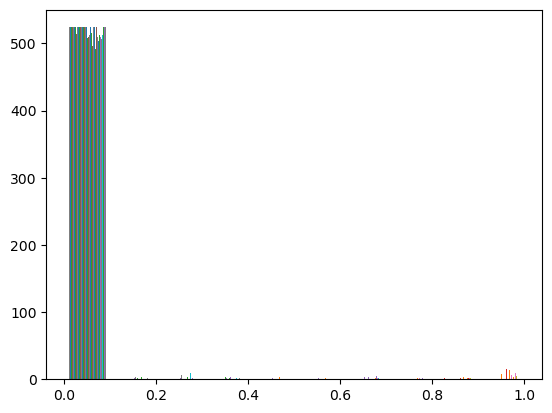

In [20]:
"""
from histogram below, we use a threshold of 0.5
for detection of object

"""
plt.hist(blurred_image,bins=10)

In [8]:
"""
we prepare our image as xr.dataArrays for further usage

"""
da = xr.DataArray(np.asarray(blurred_image), name='image', dims=("x", "y"))
da = da.assign_coords(x=np.arange(da.shape[0]), y=np.arange(da.shape[1]))

"""
detect the object in the image using 0.5 as threshold and 0.85 as wavelet threshold

"""
labels=extract_objects(
    da,
    10,
    0.5,
    0.85,
)

--> 1 objects detected 



In [9]:
"""
use the detected object to extract their contour

"""
contours=extract_contours(
    da,
    labels,
    False,
    8,
    200,
    10,
    "histogram",
    0,
)

--> 12 contours extracted over 1 retained objects



In [13]:
"""
use the contours of objects to compute levelset

"""
levelset=contours_2_levelset(contours,da,False)

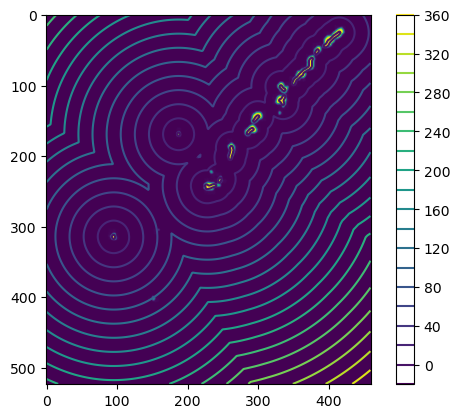

In [19]:
plt.imshow(blurred_image)
plt.contour(levelset,20)
plt.colorbar()

In [22]:
curv=curvature(levelset)

(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array([-1.85046622, -1.46541967, -1.08037312, -0.69532657, -0.31028002,
         0.07476653,  0.45981309,  0.84485964,  1.22990619,  1.61495274,
         1.99999929]),
 <a list of 460 BarContainer objects>)

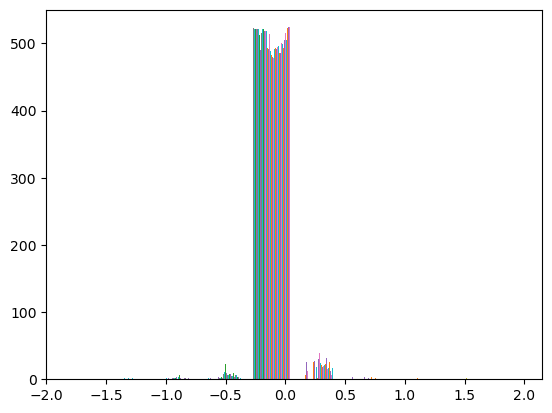

In [24]:
plt.hist(curv,10)